In [17]:
import matplotlib.pyplot as plt
import torch
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 7.0)
#set all background colors of plot to white in matplotlib
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = 'white'
matplotlib.rcParams['axes.labelcolor'] = 'black'
import random
import numpy as np


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.mps.deterministic = True


In [18]:
import tqdm.notebook as tqdm

In [19]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3, shuffle=True)


In [21]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [22]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(13, n_hidden)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        """
        We don't use softmax here because we are going to use cross-entropy loss, which implicitly performs softmax
        """
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    

In [23]:
wine_net = WineNet(5)

In [24]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [25]:
batch_size = 10

for epoch in tqdm.tqdm(range(10000), "Epochs"):
    order = np.random.permutation(len(X_train_tensor))
    for start_index in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = wine_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        
        loss_value.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test_tensor)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test_tensor).float().mean())
        
    

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.2593)
tensor(0.7222)
tensor(0.7037)
tensor(0.6852)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.6667)
tensor(0.7222)
tensor(0.6481)
tensor(0.7222)
tensor(0.6852)
tensor(0.5741)
tensor(0.7407)
tensor(0.6852)
tensor(0.5741)
tensor(0.6296)
tensor(0.7407)
tensor(0.6111)
tensor(0.7037)
tensor(0.6111)
tensor(0.6667)
tensor(0.6481)
tensor(0.6481)
tensor(0.7593)
tensor(0.6296)
tensor(0.7778)
tensor(0.7963)
tensor(0.6852)
tensor(0.6481)
tensor(0.7037)
tensor(0.7407)
tensor(0.8148)
tensor(0.7037)
tensor(0.8333)
tensor(0.8148)
tensor(0.8148)
tensor(0.8519)
tensor(0.8148)
tensor(0.7037)
tensor(0.8333)
tensor(0.7963)
tensor(0.7778)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8148)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.7963)
tensor(0.8704)
tensor(0.8

/var/folders/9w/5jg8q39j0lb50m13v89wlvbh0000gn/T/ipykernel_27149/1669927702.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


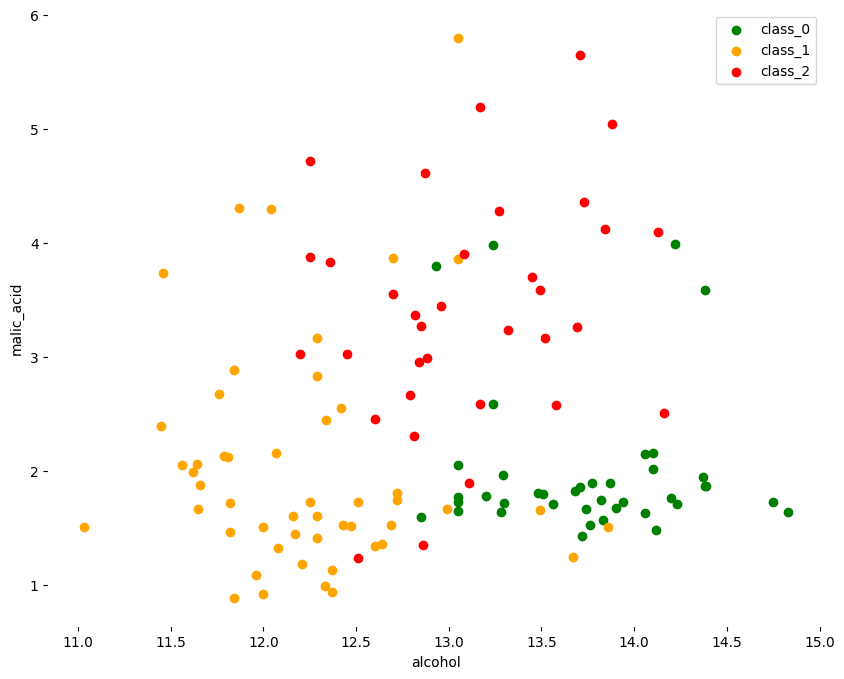

In [27]:
plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'red']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

# preds = wine_net.inference(
#     torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))
# 
# preds_class = preds.data.numpy().argmax(axis=1)
# preds_class = preds_class.reshape(xx.shape)
# plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()